In [49]:
# eda_online_retail.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# === 1. Load the Data ===
# Replace the file path if necessary.
data_path = "../data/online_retail_II.csv"
df = pd.read_csv(data_path, encoding='latin1')  # Sometimes these files have latin1 encoding
print("Raw Data Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nSample Data:")
print(df.head())

Raw Data Shape: (1067371, 8)
Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

Sample Data:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [35]:
# === 2. Data Cleaning ===

# Inspect for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Drop rows with missing CustomerID since they hinder customer-based analysis.
df = df.dropna(subset=["Customer ID"])
print("Shape after dropping missing Customer ID:", df.shape)

# Remove duplicates
df = df.drop_duplicates()
print("Shape after dropping duplicates:", df.shape)

# Remove cancellations/returns:
# Usually, cancellations have Invoice numbers starting with 'C'
df = df[~df["Invoice"].astype(str).str.startswith("C")]
print("Shape after removing cancellations:", df.shape)

# Convert data types
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Quantity"] = df["Quantity"].astype(int)
df["Price"] = df["Price"].astype(float)

# Create a new column: TotalPrice (for each transaction line)
df["TotalPrice"] = df["Quantity"] * df["Price"]


Missing values per column:
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64
Shape after dropping missing Customer ID: (824364, 8)
Shape after dropping duplicates: (797885, 8)
Shape after removing cancellations: (779495, 8)


In [36]:

# === 3. Feature Engineering ===

# Create an RFM (Recency, Frequency, Monetary) analysis frame for customers
snapshot_date = df["InvoiceDate"].max() + dt.timedelta(days=1)
rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency: days since last purchase
    "Invoice": "nunique",  # Frequency: count of unique invoices
    "TotalPrice": "sum"    # Monetary: total spend
}).reset_index()
rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

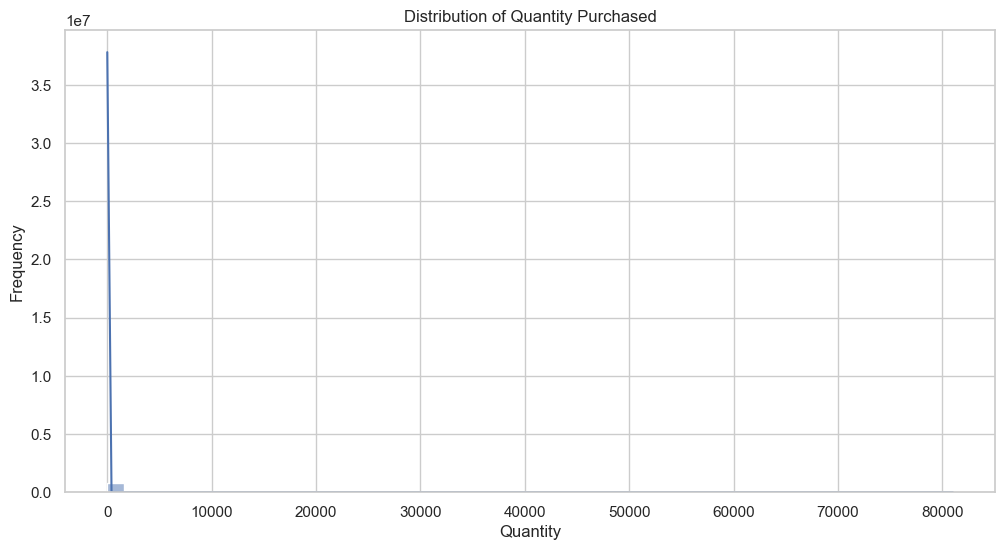

In [37]:
# === 4. Data Visualization ===

## 4.1 Overall Data Distributions

# Distribution of Quantity
plt.figure()
sns.histplot(df["Quantity"], bins=50, kde=True)
plt.title("Distribution of Quantity Purchased")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.savefig("../notebooks/plots/quantity_distribution.png")
plt.show()

💬 Explanation:
This initial plot shows the distribution of Quantity purchased across all transactions. However, it appears heavily skewed, with most values squashed on the left of the x-axis.

This distortion is caused by extreme outliers in the dataset — a few purchases have extremely high quantities (some even over 80,000 units) while the vast majority are small values (like 1 to 10).

As a result, the scale is dominated by these rare large values, and we can’t clearly see the shape of the common purchase distribution.

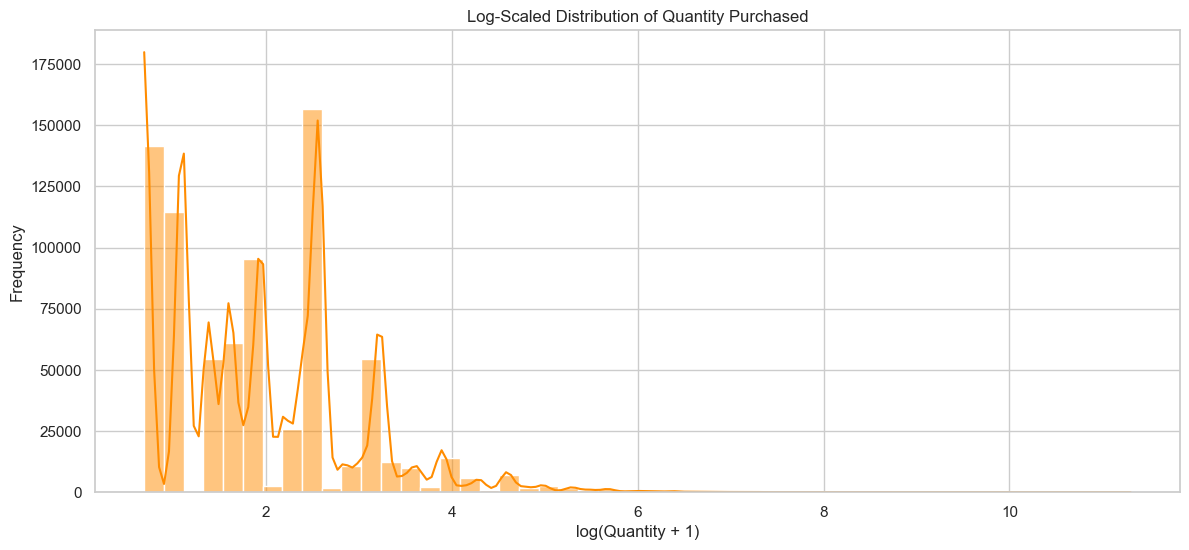

In [38]:
import numpy as np

# Filter only positive quantities to apply log safely
df_pos = df[df["Quantity"] > 0].copy()
df_pos["log_quantity"] = np.log1p(df_pos["Quantity"])  # log(1 + x)

plt.figure(figsize=(14, 6))
sns.histplot(df_pos["log_quantity"], bins=50, kde=True, color="darkorange")
plt.title("Log-Scaled Distribution of Quantity Purchased")
plt.xlabel("log(Quantity + 1)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


💬 Explanation:
To fix the skewed view, we applied a log transformation using log(Quantity + 1). This compresses large values and spreads out smaller ones, making it easier to visualize the underlying distribution.

Now we can see that most purchases are clustered in the lower quantity range, and the curve shows a right-skewed distribution — still imbalanced, but readable.

This technique is useful in exploratory data analysis (EDA) when dealing with highly skewed numerical data.

❗ Why Did My Plot Look Broken? Because outliers matter. A few massive orders distorted the view.

🛠 Solution? Use log-scale to normalize the scale, then visualize again.

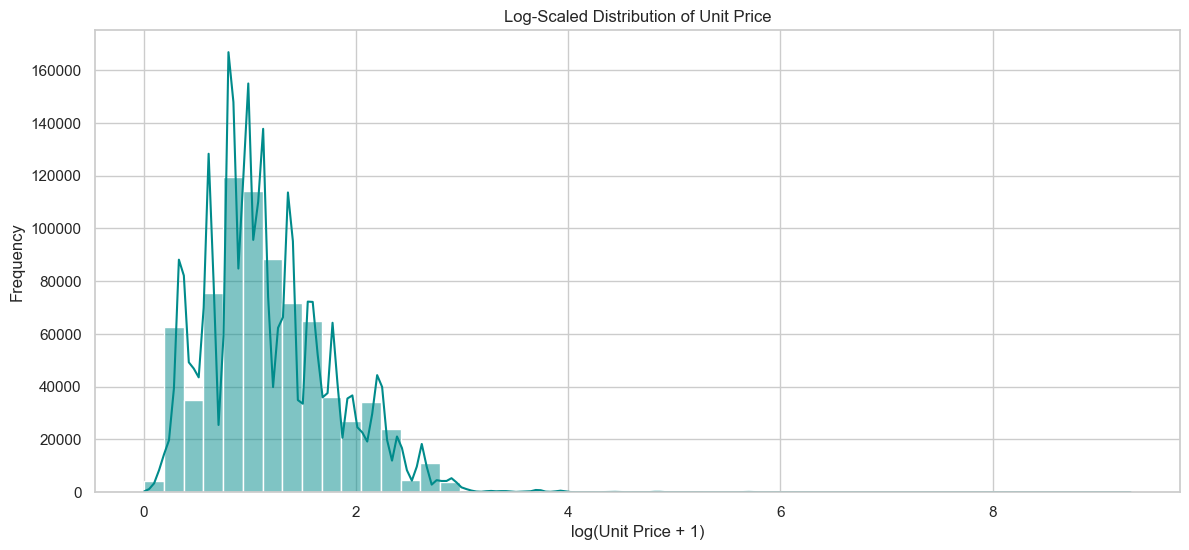

In [39]:
df_pos_price = df[df["Price"] > 0].copy()
df_pos_price["log_price"] = np.log1p(df_pos_price["Price"])

plt.figure(figsize=(14, 6))
sns.histplot(df_pos_price["log_price"], bins=50, kde=True, color="darkcyan")
plt.title("Log-Scaled Distribution of Unit Price")
plt.xlabel("log(Unit Price + 1)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

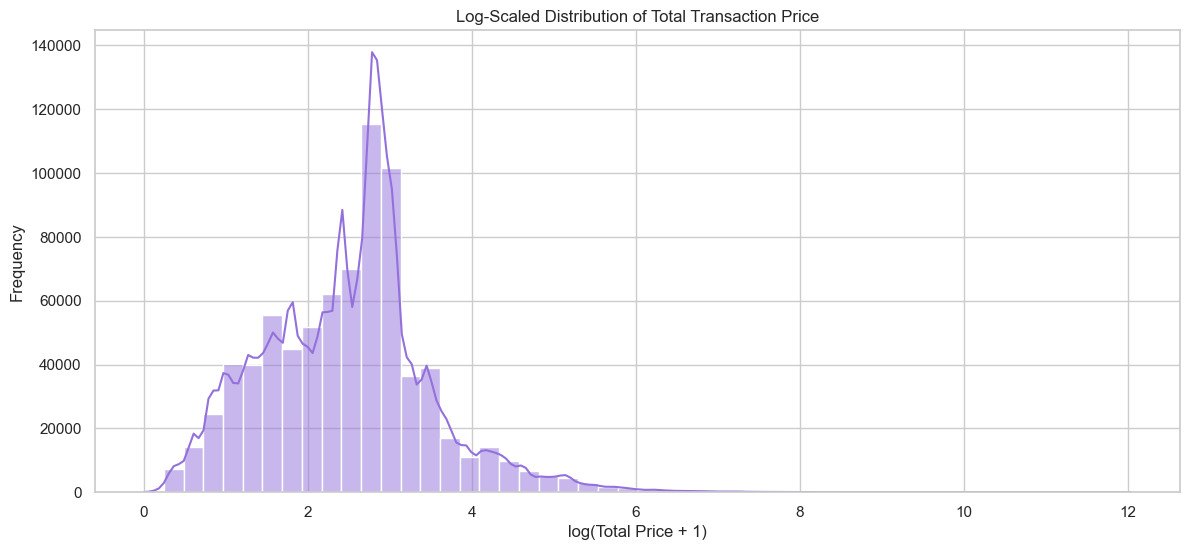

In [40]:
df_pos_total = df[df["TotalPrice"] > 0].copy()
df_pos_total["log_total"] = np.log1p(df_pos_total["TotalPrice"])

plt.figure(figsize=(14, 6))
sns.histplot(df_pos_total["log_total"], bins=50, kde=True, color="mediumpurple")
plt.title("Log-Scaled Distribution of Total Transaction Price")
plt.xlabel("log(Total Price + 1)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

💬 Explanation:
Applying a log transformation helps normalize the scale, revealing the underlying shape. The distribution is still slightly skewed but now provides a clear view of price tiers across products.

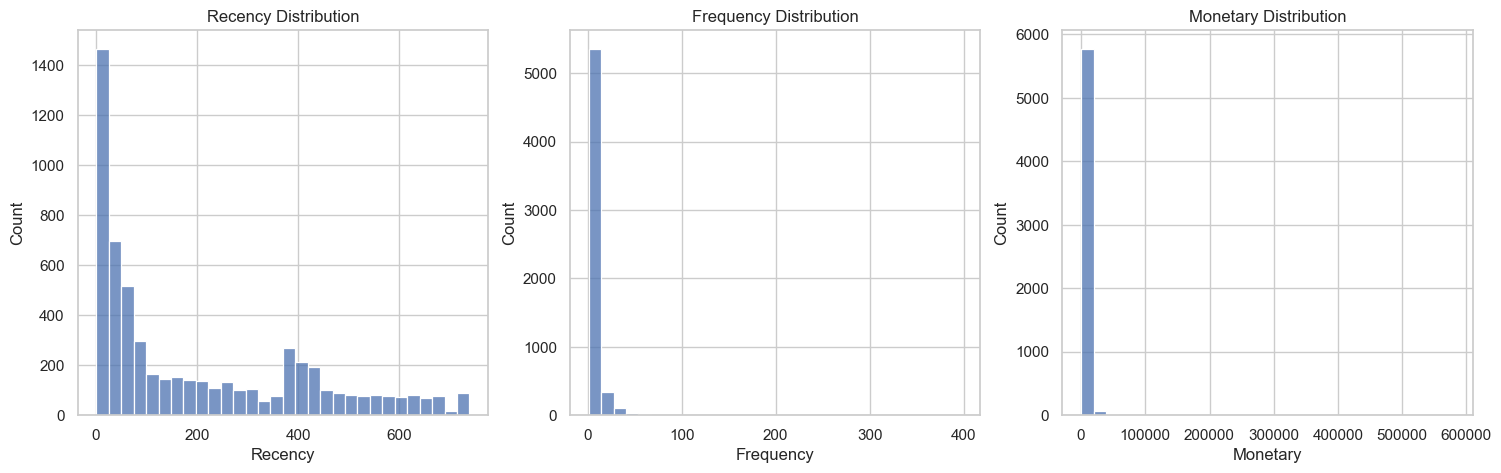

In [41]:
## 4.2 Customer Segmentation (RFM Analysis)

# Plot histograms for RFM values
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm["Recency"], bins=30, ax=axes[0])
axes[0].set_title("Recency Distribution")
sns.histplot(rfm["Frequency"], bins=30, ax=axes[1])
axes[1].set_title("Frequency Distribution")
sns.histplot(rfm["Monetary"], bins=30, ax=axes[2])
axes[2].set_title("Monetary Distribution")
plt.savefig("plots/rfm_distributions.png")
plt.show()

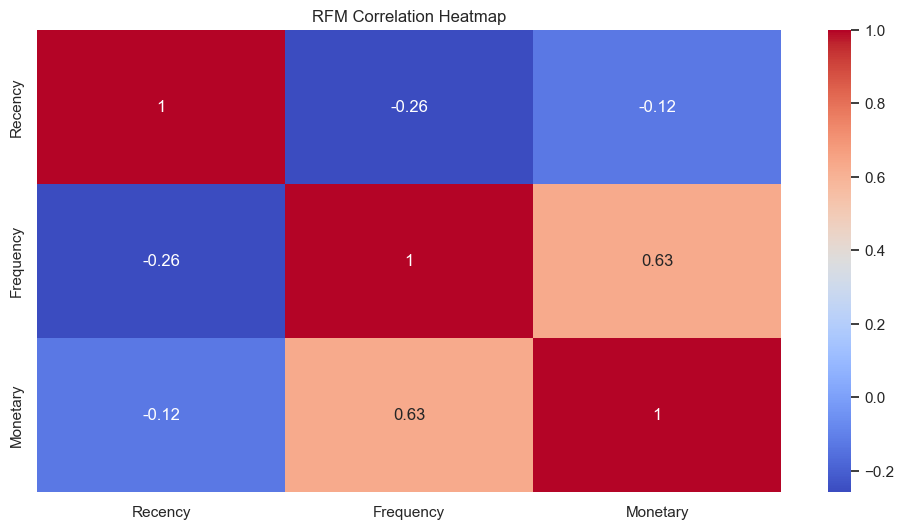

In [42]:
# Correlation heatmap for RFM
plt.figure()
corr = rfm[["Recency", "Frequency", "Monetary"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("RFM Correlation Heatmap")
plt.savefig("plots/rfm_correlation.png")
plt.show()

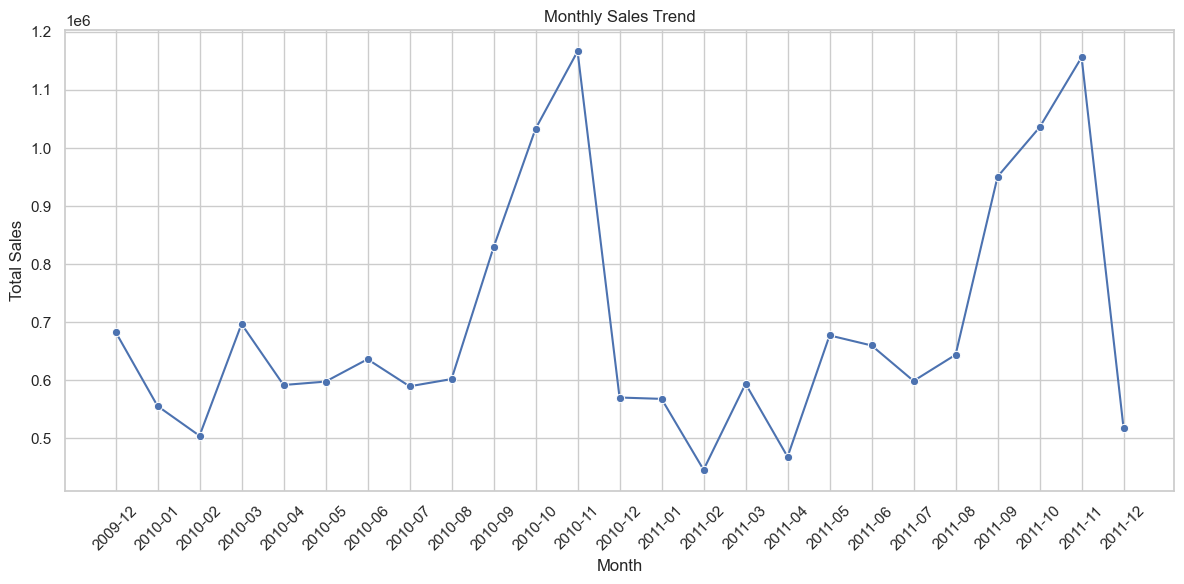

In [43]:
## 4.3 Sales Over Time

# Aggregate sales per month
df["Month"] = df["InvoiceDate"].dt.to_period("M")
monthly_sales = df.groupby("Month")["TotalPrice"].sum().reset_index()
monthly_sales["Month"] = monthly_sales["Month"].astype(str)

plt.figure()
sns.lineplot(data=monthly_sales, x="Month", y="TotalPrice", marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.savefig("plots/monthly_sales.png")
plt.show()

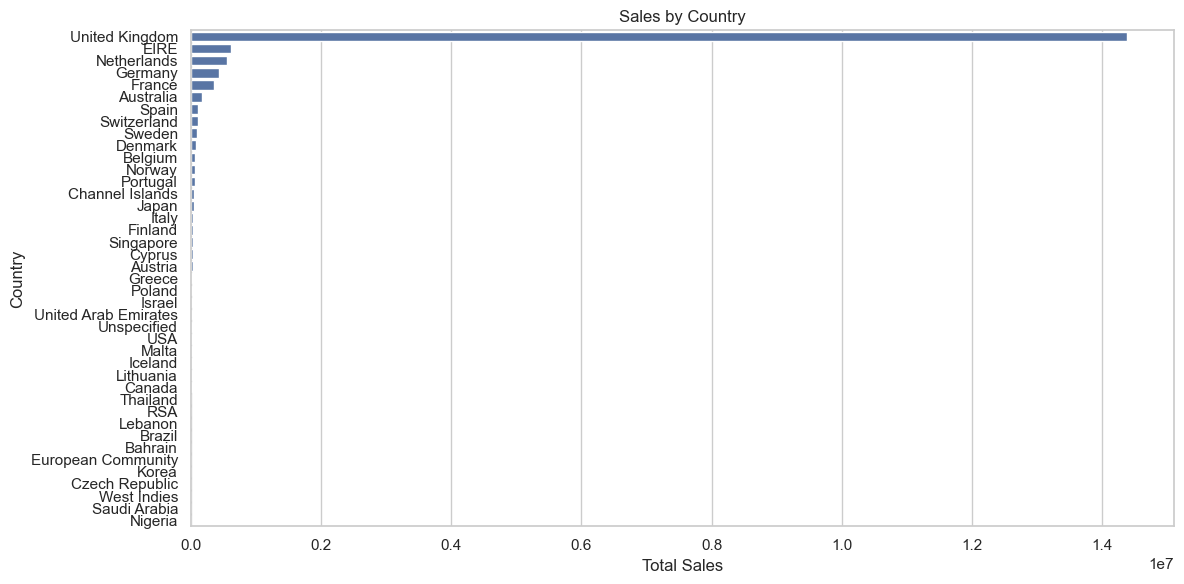

In [44]:

# Sales by Country
country_sales = df.groupby("Country")["TotalPrice"].sum().reset_index().sort_values(by="TotalPrice", ascending=False)
plt.figure()
sns.barplot(data=country_sales, x="TotalPrice", y="Country")
plt.title("Sales by Country")
plt.xlabel("Total Sales")
plt.ylabel("Country")
plt.tight_layout()
plt.savefig("plots/country_sales.png")
plt.show()

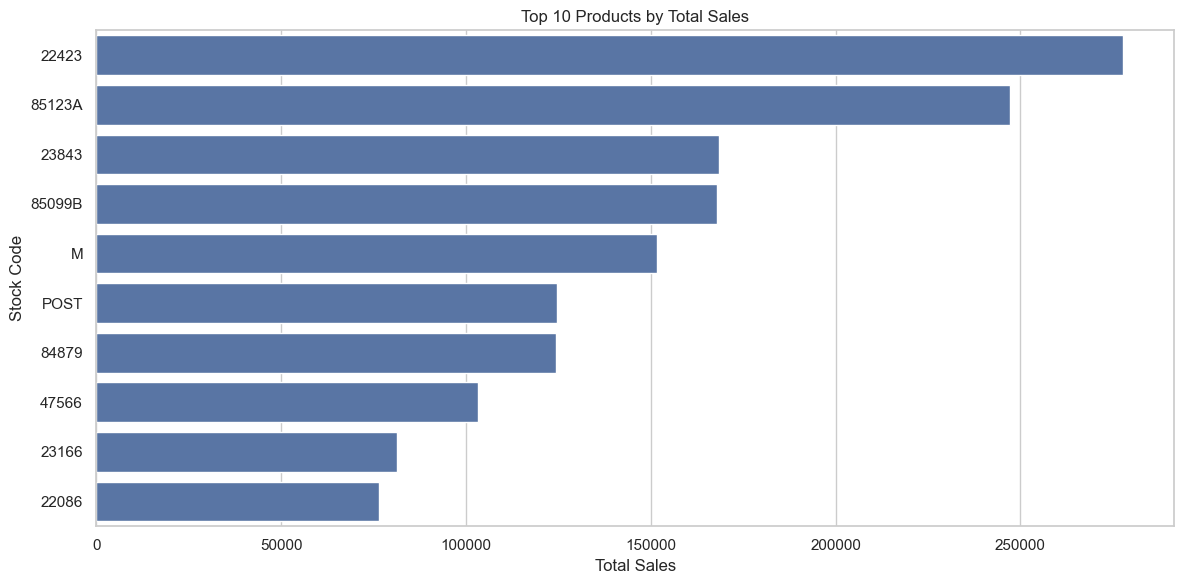

In [45]:
## 4.5 Top 10 Products (by Total Price)
# Assuming "StockCode" represents products. You can use "Description" if available.
top_products = df.groupby("StockCode")["TotalPrice"].sum().reset_index().sort_values(by="TotalPrice", ascending=False).head(10)
plt.figure()
sns.barplot(data=top_products, x="TotalPrice", y="StockCode")
plt.title("Top 10 Products by Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Stock Code")
plt.tight_layout()
plt.savefig("plots/top_products.png")
plt.show()

In [46]:
# Save the cleaned transactions and RFM summary for later steps
df.to_csv("../data/transactions_clean.csv", index=False)
rfm.to_csv("../data/rfm_summary.csv", index=False)
print("✅ EDA complete. Processed data saved and plots generated in the 'plots/' folder.")

✅ EDA complete. Processed data saved and plots generated in the 'plots/' folder.


In [47]:
print("hello hjkworld")

hello hjkworld


📖 Storytelling EDA Walkthrough
## Step 1: Exploratory Data Analysis (EDA)
🔍 1.1 Create a Python Script for EDA
We kick off the exploration by creating a dedicated Python script to handle EDA. This file acts as the first formal analysis point of the project. By organizing our code here, we keep things modular, repeatable, and clean.

🧾 1. Load the Data
We load the Online Retail II dataset using pandas, carefully using 'latin1' encoding to avoid any import errors caused by special characters. This gives us a raw view of the dataset—rows, columns, and a few sample transactions. It sets the stage for everything that follows.

🧼 2. Data Cleaning
Before diving deeper, we need to tidy the data:

We check for missing values, especially Customer ID, which is essential for customer-level analysis.

Rows missing Customer ID are dropped because we cannot associate them with a shopper.

We remove duplicate rows to prevent double-counting.

We filter out cancellations/returns, which are identified by invoices starting with "C", since these do not reflect actual purchases.

Then, we convert data types: converting date strings to datetime, prices to floats, and quantities to integers.

Finally, we create a new TotalPrice column that captures the monetary value of each line item (Quantity × UnitPrice).

🧱 3. Feature Engineering
We build a new dataset based on RFM Analysis, a classic customer segmentation method:

Recency: How many days ago the customer last made a purchase.

Frequency: How many unique invoices they’ve been part of.

Monetary: How much money they’ve spent overall.

This step transforms our data from transaction-level to customer-level—crucial for personalization and behavior modeling later on.

📊 4. Data Visualization
📦 4.1 Overall Data Distributions
We visualize the basic distribution of core numeric fields:

Quantity: How many units are purchased per line item.

Unit Price: The price per item—great for identifying low-end vs premium products.

Total Price: Total value per transaction line, giving us a peek into high- vs low-value purchases.

These histograms help us understand patterns, skewness, and detect anomalies like extreme values or price errors.

👥 4.2 Customer Segmentation (RFM Analysis)
With the RFM table created, we explore the distributions of each component:

Some customers haven’t purchased in a while (high Recency),

Some are frequent shoppers (high Frequency),

And some spend big (high Monetary).

We also visualize the correlation heatmap between R, F, and M—this helps us spot if any patterns exist (e.g., do frequent buyers spend more?).

📈 4.3 Sales Over Time
Here we zoom out to the business level. By aggregating total sales by month, we create a monthly trend line. This helps spot:

Peaks and dips in sales,

Seasonality (e.g., holidays),

Business performance over time.

It’s a powerful way to inform inventory planning and marketing calendars.

🌍 4.4 Top Countries by Sales
By grouping sales by country, we identify where the business is thriving and which regions bring the most revenue. This helps in market prioritization, logistics, and even localized promotions.

🏆 4.5 Top 10 Products (by Total Price)
Finally, we look at the top-performing products based on total revenue. This is essential for product strategy—knowing your best sellers lets you optimize stock, create bundles, or highlight them in marketing campaigns.

💾 5. Save the Processed Data
We wrap up by saving two key files:

The cleaned transaction dataset: transactions_clean.csv

The customer-level RFM summary: rfm_summary.csv

These files are ready to be used in further analysis, dashboards, machine learning models, or AI-powered search/chat interfaces.

✅ All plots have been saved into a plots/ folder for reporting and presentation use.

